In [1]:
from torch import nn
import torch
import pandas as pd
import numpy as np
import os
from torchvision.io import read_image
from torchvision import datasets
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import transforms3d as tf
from vit_pytorch.vit_3d import ViT
from typing import Dict, List, Tuple
from IPython.display import clear_output

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [39]:
def matrix_from_df_row(row: pd.Series) -> np.ndarray:
    R = np.array(tf.quaternions.quat2mat((row['qw'], row['qx'], row['qy'], row['qz'])))
    t = np.array([[row['tx'], row['ty'], row['tz']]])
    Rt = np.concatenate((np.concatenate((R, t.T), axis=1), np.array([[0, 0, 0, 1]])))
    return Rt


def matrix_from_row(row: List[float]) -> np.ndarray:
    tx, ty, tz, qx, qy, qz, qw = row
    R = np.array(tf.quaternions.quat2mat((qw, qx, qy, qz)))
    t = np.array([[tx, ty, tz]])
    Rt = np.concatenate((np.concatenate((R, t.T), axis=1), np.array([[0, 0, 0, 1]])))
    return Rt


def df_row_from_matrix(T: np.ndarray) -> pd.Series:
    row = pd.Series(index=['timestamp', 'tx', 'ty', 'tz', 'qx', 'qy', 'qz', 'qw'], dtype=np.float64)
    row['tx'], row['ty'], row['tz'] = T[0:3, 3]
    # row['ty'] = T[1, 3]
    # row['tz'] = T[2, 3]
    quat = tf.quaternions.mat2quat(T[:3, :3])
    row['qw'], row['qx'], row['qy'], row['qz'] = quat
    return row


def load_fpv_data(data_dirs: List[str], seq_len: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Process data in directories and return list of sequences of images (X) and difference in ground truth poses during sequence (y)
    This function expect data format from FPV dataset.

    Currently it uses quaternion representation, it might be interesting to explore other options:
    https://arxiv.org/pdf/1812.07035.pdf
    """

    all_vid_df = []
    all_vid_gt_df = []

    for data_dir in data_dirs:
        gt_fn = data_dir + 'groundtruth.txt'
        img_left_files_fn = data_dir + 'left_images.txt'
        img_right_files_fn = data_dir + 'right_images.txt'
        imu_fn = data_dir + 'imu.txt'

        orig_gt_df = pd.read_csv(gt_fn, delimiter=' ', skiprows=1, names=['timestamp', 'tx', 'ty', 'tz', 'qx', 'qy', 'qz', 'qw'])
        imgs_left_df = pd.read_csv(img_left_files_fn, delimiter=' ', skiprows=1, names=['id', 'timestamp', 'image_name', ''])
        imgs_right_df = pd.read_csv(img_right_files_fn, delimiter=' ', skiprows=1, names=['id', 'timestamp', 'image_name', ''])
        imu_df = pd.read_csv(imu_fn, delimiter=' ', skiprows=1,
                             names=['id', 'timestamp', 'ang_vel_x', 'ang_vel_y', 'ang_vel_z', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z'])

        # Filter only images with ground truth data
        first_img = imgs_left_df[imgs_left_df.timestamp > orig_gt_df.iloc[0].timestamp].index[0] - 1
        last_img = imgs_left_df[imgs_left_df.timestamp > orig_gt_df.iloc[-1].timestamp].index[0] - 1
        viable_imgs_left_df = imgs_left_df.iloc[first_img:last_img + 1]
        viable_imgs_right_df = imgs_right_df.iloc[first_img:last_img + 1]

        # Filter only IMU readings with ground truth data
        first_imu = imu_df[imu_df.timestamp > orig_gt_df.iloc[0].timestamp].index[0] - 1
        last_imu = imu_df[imu_df.timestamp > orig_gt_df.iloc[-1].timestamp].index[0] - 1
        viable_imu_df = imu_df.iloc[first_imu:last_imu + 1]

        gt_df = pd.DataFrame(index=range(len(viable_imgs_left_df)), columns=['timestamp', 'tx', 'ty', 'tz', 'qx', 'qy', 'qz', 'qw'])
        for (_, img_row), (_, gt_row) in zip(viable_imgs_left_df.iterrows(), gt_df.iterrows()):
            gt_row[:] = orig_gt_df[orig_gt_df.timestamp >= img_row.timestamp].iloc[0]

        dataset_len = len(viable_imgs_left_df) - seq_len + 1
        columns = [f'left_{i}' for i in range(seq_len)] + [f'right_{i}' for i in range(seq_len)] + ['imu']
        vid_df = pd.DataFrame(index=range(dataset_len), columns=columns)
        vid_gt_df = pd.DataFrame(index=range(dataset_len), columns=['timestamp', 'tx', 'ty', 'tz', 'qx', 'qy', 'qz', 'qw'])

        for i in range(dataset_len):
            imus = viable_imu_df[viable_imu_df.timestamp > viable_imgs_left_df.iloc[i].timestamp]
            imus = imus[imus.timestamp <= viable_imgs_left_df.iloc[i + seq_len - 1].timestamp]
            imus = imus[[ 'ang_vel_x', 'ang_vel_y', 'ang_vel_z', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z']].to_numpy()

            vid_df.iloc[i] = \
                list(data_dir + viable_imgs_left_df.iloc[i:i + seq_len]['image_name']) + \
                list(data_dir + viable_imgs_right_df.iloc[i:i + seq_len]['image_name']) + [imus]

            # Calculate pose difference
            T0 = matrix_from_df_row(gt_df.iloc[i + seq_len - 2])
            Tend = matrix_from_df_row(gt_df.iloc[i + seq_len - 1])
            Tdiff = np.matmul(np.linalg.inv(T0), Tend)

            row = df_row_from_matrix(Tdiff)
            row['timestamp'] = gt_df.iloc[i + seq_len - 1]['timestamp']
            # row['timestamp'] =
            # print(row)
            vid_gt_df.iloc[i] =  row
            # print(vid_gt_df.iloc[i])

        all_vid_df.append(vid_df)
        all_vid_gt_df.append(vid_gt_df)

    return pd.concat(all_vid_df), pd.concat(all_vid_gt_df)

In [23]:
class VideoMonoImuDataset(Dataset):
    def __init__(self, vid_df: pd.DataFrame, gt_df: pd.DataFrame, new_size: Tuple[int, int]):
        seq_len = len(train_vid_df.columns) // 2
        self.vid_df = vid_df[[f'left_{i}' for i in range(seq_len)]]
        self.imu_df = vid_df['imu']
        self.gt_df = gt_df
        self.transformer = transforms.Compose([
            # transforms.Resize((new_size[1], new_size[0])),  # swap order
            transforms.CenterCrop((new_size[1], new_size[0])),  # swap order
            transforms.ToTensor(),  # TODO: we could additionally normalize data
        ])

        self.cache: Dict[str, Image.Image] = {}

    def __len__(self) -> int:
        return len(self.vid_df)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        imgs = [self._get_from_cache(path) for path in self.vid_df.iloc[idx]]
        imgs = [self.transformer(img) for img in imgs]
        imgs = torch.stack(imgs)
        imgs = torch.permute(imgs, (1, 0, 2, 3))

        imu = torch.tensor(self.imu_df.iloc[idx])

        gt = torch.tensor(list(self.gt_df.iloc[idx]))

        return imgs, imu, gt

    def _get_from_cache(self, path: str):
        if path not in self.cache:
            self.cache[path] = Image.open(path)
        return self.cache[path]

class VideoStereoImuDataset(Dataset):
    def __init__(self, vid_df: pd.DataFrame, gt_df: pd.DataFrame, new_size: Tuple[int, int]):
        self.seq_len = len(train_vid_df.columns) // 2
        self.vid_df_left = vid_df[[f'left_{i}' for i in range(self.seq_len)]]
        self.vid_df_right = vid_df[[f'right_{i}' for i in range(self.seq_len)]]
        self.imu_df = vid_df['imu']
        self.gt_df = gt_df
        self.transformer = transforms.Compose([
            # transforms.Resize((new_size[1], new_size[0])),  # swap order
            transforms.CenterCrop((new_size[1], new_size[0])),  # swap order
            transforms.ToTensor(),  # TODO: we could additionally normalize data
        ])

        self.cache: Dict[str, Image.Image] = {}

    def __len__(self) -> int:
        return len(self.vid_df_left)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, float]:
        imgs_left = [self._get_from_cache(path) for path in self.vid_df_left.iloc[idx]]
        imgs_right = [self._get_from_cache(path) for path in self.vid_df_right.iloc[idx]]
        imgs_left = [self.transformer(img) for img in imgs_left]
        imgs_right = [self.transformer(img) for img in imgs_right]
        # merge images vertically
        imgs = [torch.cat((left, right), 1) for left, right in zip(imgs_left, imgs_right)]

        imgs = torch.stack(imgs)
        imgs = torch.permute(imgs, (1, 0, 2, 3))

        imu = torch.tensor(self.imu_df.iloc[idx]).float()
        padded_size = 20 * self.seq_len
        imu = nn.functional.pad(imu, pad=(0, 0, 0, padded_size - imu.shape[0]))

        gt = torch.tensor(list(self.gt_df.iloc[idx])[1:])
        timestamp = list(self.gt_df.iloc[idx])[0]

        return imgs, imu, gt, timestamp

    def _get_from_cache(self, path: str):
        if path not in self.cache:
            self.cache[path] = Image.open(path)
        return self.cache[path]


In [24]:
#################################################################
######################     PARAMETERS      ######################
#################################################################

# Better resolution seems to have big impact on accuracy
img_size = (640 // 4, 480 // 4)
# img_size = (210, 160)

# seq_len = 6
seq_len = 4

batch_size = 4

# 9 and 10 make 8-shapes which can be easy to visually evaluate
train_data_dirs = [f'indoor_forward_{i}_snapdragon_with_gt/' for i in [6, 7, 101, 103, 9]]
# train_data_dirs = [f'indoor_forward_{i}_snapdragon_with_gt/' for i in [9]]

In [25]:
# valid_data_dirs = [f'indoor_forward_{i}_snapdragon_with_gt/' for i in [5, 10, 105]]
valid_data_dirs = [f'indoor_forward_{i}_snapdragon_with_gt/' for i in [10]]

In [45]:
train_vid_df, train_vid_gt_df = load_fpv_data(train_data_dirs, seq_len=seq_len)

In [41]:
valid_vid_df, valid_vid_gt_df = load_fpv_data(valid_data_dirs, seq_len=seq_len)

timestamp    1540822844.7828
tx                  0.000375
ty                  0.000337
tz                 -0.000038
qx                 -0.000001
qy                 -0.000081
qz                 -0.000112
qw                       1.0
Name: 6, dtype: object
timestamp    1540822844.8148
tx                  0.000307
ty                  0.000327
tz                 -0.000083
qx                  0.000003
qy                 -0.000022
qz                 -0.000089
qw                       1.0
Name: 7, dtype: object
timestamp    1540822844.8488
tx                  0.000275
ty                  0.000329
tz                  -0.00004
qx                 -0.000023
qy                  0.000011
qz                 -0.000048
qw                       1.0
Name: 8, dtype: object
timestamp    1540822844.8828
tx                  0.000231
ty                  0.000271
tz                  0.000136
qx                 -0.000057
qy                 -0.000007
qz                 -0.000003
qw                       1.0
Nam

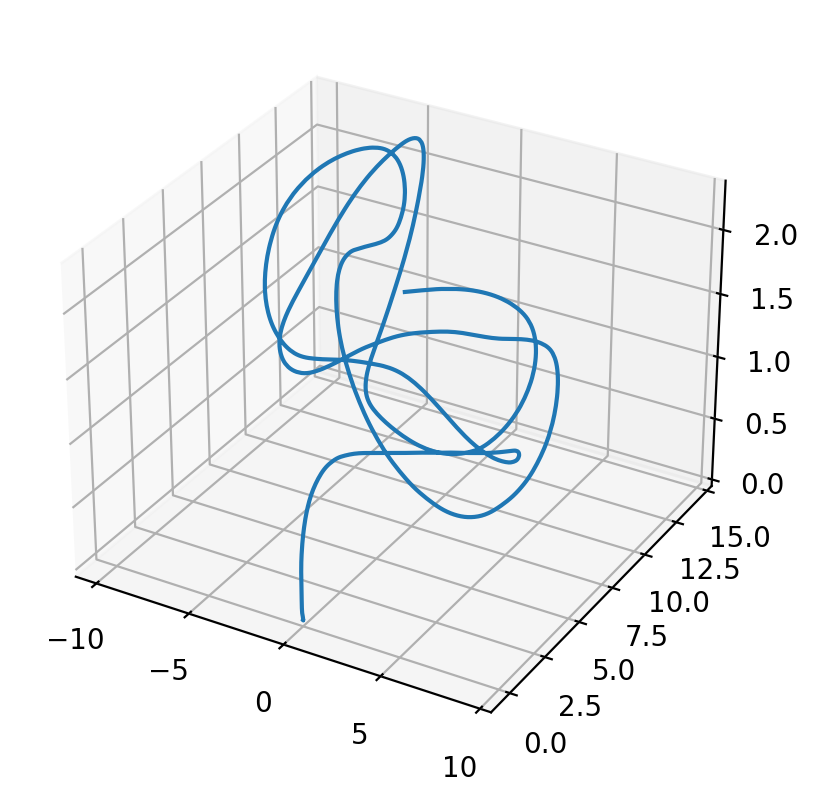

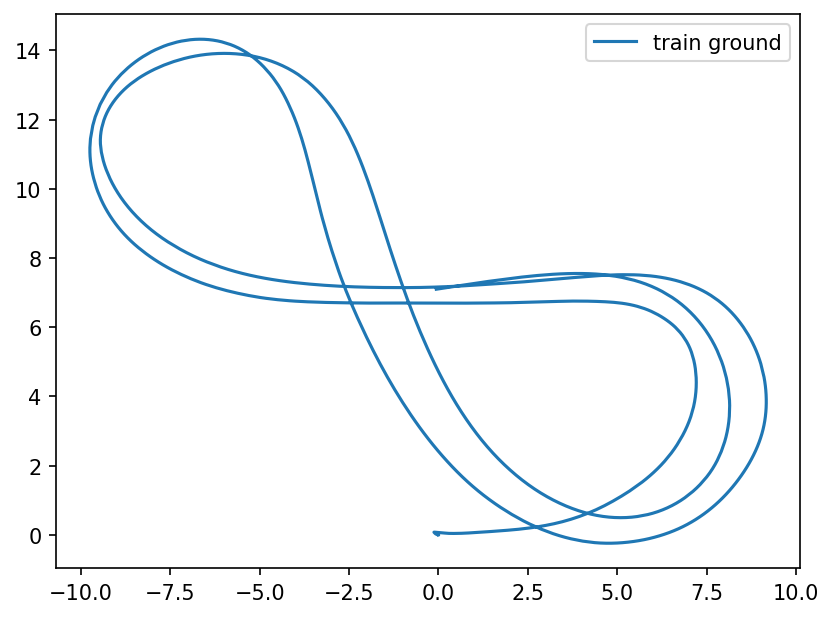

In [46]:
ground = []
x = np.eye(4)
gtx = np.eye(4)
data9_range = range(len(train_vid_gt_df) - 758, len(train_vid_gt_df))

for i in data9_range:
    gt = train_vid_gt_df.iloc[i]
    # delta_gt = matrix_from_df_row(pd.Series(gt.numpy(), index=['tx', 'ty', 'tz', 'qx', 'qy', 'qz', 'qw']))
    print(gt)
    delta_gt = matrix_from_df_row(gt)
    gtx = np.matmul(gtx, delta_gt)
    ground.append(gtx.copy()[:3, 3])

ground = np.array(ground).reshape(-1,3)
fig = plt.figure(dpi=200)
ax = plt.axes(projection='3d')
ax.plot3D(ground[:,0],ground[:,1],ground[:,2])

plt.figure(2, dpi=150)
plt.plot(ground[:,0],ground[:,1])
plt.legend(["train ground"])

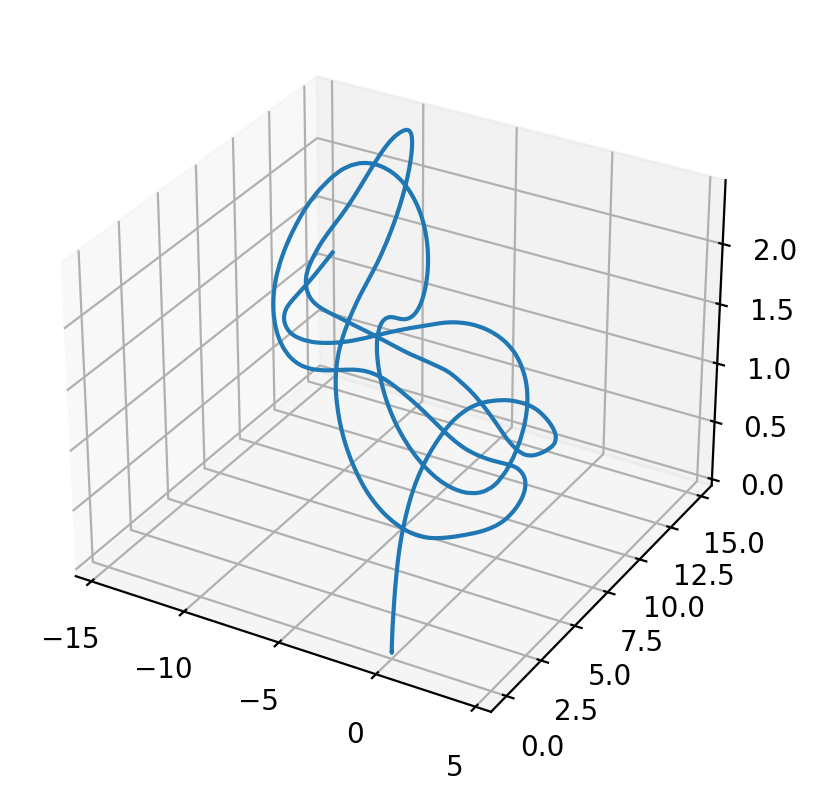

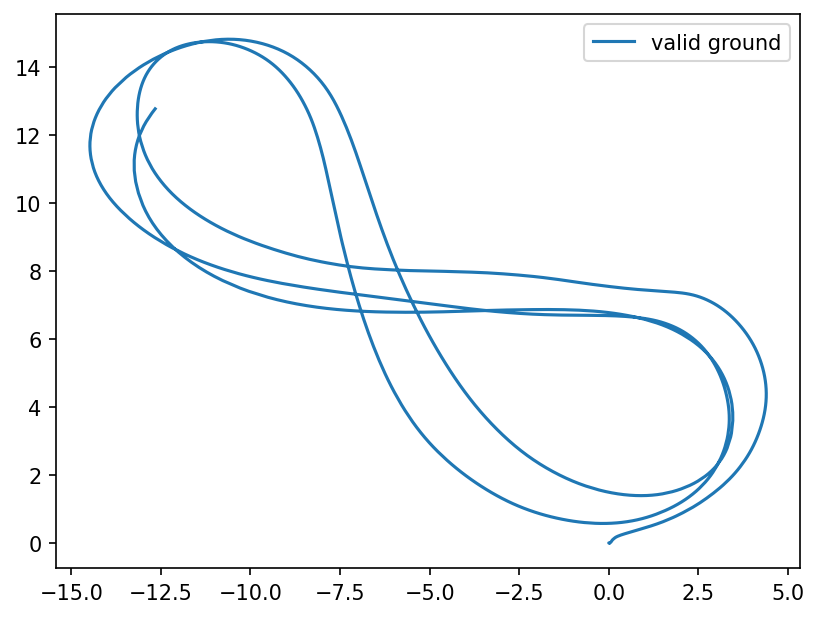

In [47]:
ground_valid = []
gtx = np.eye(4)

for i in range(len(valid_vid_gt_df)):
    gt = valid_vid_gt_df.iloc[i]
    # delta_gt = matrix_from_df_row(pd.Series(gt.numpy(), index=['tx', 'ty', 'tz', 'qx', 'qy', 'qz', 'qw']))
    delta_gt = matrix_from_df_row(gt)
    gtx = np.matmul(gtx, delta_gt)
    ground_valid.append(gtx.copy()[:3, 3])

ground_valid = np.array(ground_valid).reshape(-1, 3)
fig = plt.figure(dpi=200)
ax = plt.axes(projection='3d')
ax.plot3D(ground_valid[:, 0], ground_valid[:, 1], ground_valid[:, 2])

plt.figure(2, dpi=150)
plt.plot(ground_valid[:, 0], ground_valid[:, 1])
plt.legend(["valid ground"])

In [48]:
# train_data = VideoMonoDataset(train_vid_df, train_vid_gt_df, new_size=img_size)
# valid_data = VideoMonoDataset(valid_vid_df, valid_vid_gt_df, new_size=img_size)

train_data = VideoStereoImuDataset(train_vid_df, train_vid_gt_df, new_size=img_size)
valid_data = VideoStereoImuDataset(valid_vid_df, valid_vid_gt_df, new_size=img_size)

imgs, imus, gt, timestamp = train_data[100]
print(imgs.size())
print(imus.size())
print(gt)
print(timestamp)

torch.Size([1, 4, 240, 160])
torch.Size([80, 6])
tensor([ 0.0966, -0.1226,  0.0032, -0.0190, -0.0053,  0.0214,  0.9996])
1540821391.03298


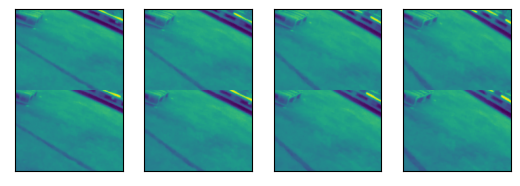

In [11]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

imgs_perm = torch.permute(imgs, (1, 0, 2, 3))
show([imgs_perm[i] for i in range(seq_len)])

In [13]:
class ImuTransformer(nn.Module):
    def __init__(self, linking_nodes):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=6, nhead=6, dim_feedforward=128, batch_first=True)
        transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
        self.encoder = transformer_encoder
        self.fc1 = nn.Linear(in_features=6, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=linking_nodes)

    def forward(self, x):
        x = torch.relu(self.encoder(x))
        x = torch.relu(self.fc1(x[:, -1, :]))
        x = self.fc2(x)
        return x


class StereImuTransformerModel(nn.Module):
    def __init__(self):
        super().__init__()

        activation_fn = torch.nn.ReLU
        linking_nodes = 32

        self.vit_model = ViT(
            image_size=max(img_size[0], 2 * img_size[1]),   # stereo
            frames=seq_len,
            image_patch_size=10,
            frame_patch_size=2,
            channels=1,
            num_classes=linking_nodes,
            dim=1024,
            depth=6,
            heads=8,
            mlp_dim=512,
            dropout=0.1,
            emb_dropout=0.1
        )

        self.imu_model = ImuTransformer(linking_nodes).double()

        self.combine_net = nn.Sequential(
            nn.Linear(2 * linking_nodes, 256),
            # nn.BatchNorm1d(256),
            activation_fn(),
            nn.Linear(256, 128),
            # nn.BatchNorm1d(128),
            activation_fn(),
            nn.Linear(128, 7, bias=False),
        )

    def forward(self, imgs, imus):
        imus = imus.double()
        imgs_out = self.vit_model(imgs)
        imus_out = self.imu_model(imus).float()

        x_combine = torch.cat([imgs_out, imus_out], dim=1)
        combine_out = self.combine_net(x_combine)

        return combine_out

model = StereImuTransformerModel()
model = model.to(device)

In [38]:
imgs, imus, _ = train_data[290]
imgs = torch.unsqueeze(imgs, 0)
imus = torch.unsqueeze(imus, 0)
print(imgs.size())
print(imus.size())
print(seq_len)

out = model(imgs.to(device), imus.to(device))
print(out)

torch.Size([1, 1, 4, 240, 160])
torch.Size([1, 80, 6])
4
tensor([[ 0.0519, -0.0188,  0.0551, -0.0110,  0.0471, -0.0350, -0.0189]],
       device='cuda:0', grad_fn=<MmBackward0>)


In [14]:
# Load previously trained model
checkpoint = torch.load('stereo_imu_model_160_120_crop_all_data.tar')
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

model.eval()

StereImuTransformerModel(
  (vit_model): ViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (f pf) (h p1) (w p2) -> b (f h w) (p1 p2 pf c)', p1=10, p2=10, pf=2)
      (1): Linear(in_features=200, out_features=1024, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (transformer): Transformer(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (attend): Softmax(dim=-1)
              (dropout): Dropout(p=0.1, inplace=False)
              (to_qkv): Linear(in_features=1024, out_features=1536, bias=False)
              (to_out): Sequential(
                (0): Linear(in_features=512, out_features=1024, bias=True)
                (1): Dropout(p=0.1, inplace=False)
              )
            )
          )
          (1): PreNorm(
            (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (f

In [65]:
# criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.1)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8)
# valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=8)

In [66]:
def my_loss(input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    trans_loss = torch.nn.functional.mse_loss(input[:, :3], target[:, :3])
    angle_loss = torch.nn.functional.mse_loss(input[:, 3:], target[:, 3:])

    return 200 * angle_loss + trans_loss
criterion = my_loss

In [41]:
losses = []

Epoch 25 / 25
----------
train Loss: 0.0121


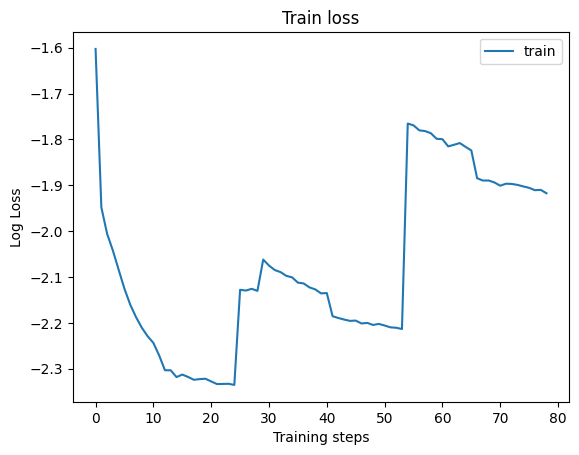

In [67]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html training loop from here

torch.cuda.empty_cache()

num_epochs = 25
for epoch in range(num_epochs):
    # print(f'Epoch {epoch + 1} / {num_epochs}')
    # print('-' * 10)

    for phase in ['train']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0

        # Iterate over data.
        for i, (in_imgs, in_imus, labels) in enumerate(train_dataloader):
            if i % 50 == 0:
                print(f'    Step {i} / {len(train_dataloader)}')
            in_imgs = in_imgs.to(device)
            in_imus = in_imus.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(in_imgs, in_imus)
                inputs_size = in_imgs.size(0)
                del in_imgs, in_imus
                torch.cuda.empty_cache()
                # outputs.size() == [4, 7]
                labels = labels.to(device)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs_size

        epoch_loss = running_loss / len(train_data)
        losses.append(epoch_loss)

        clear_output(wait=True)
        print(f'Epoch {epoch + 1} / {num_epochs}')
        print('-' * 10)
        print(f'{phase} Loss: {epoch_loss:.4f}')
        scheduler.step()

        steps = list(range(len(losses[-100:])))
        plt.figure()
        plt.plot(steps, np.log10(losses[-100:]), label='train')
        plt.xlabel('Training steps')
        plt.ylabel('Log Loss')
        plt.legend()
        plt.title("Train loss")
        plt.show()

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'stereo_imu_model_160_120_crop_all_data.tar')


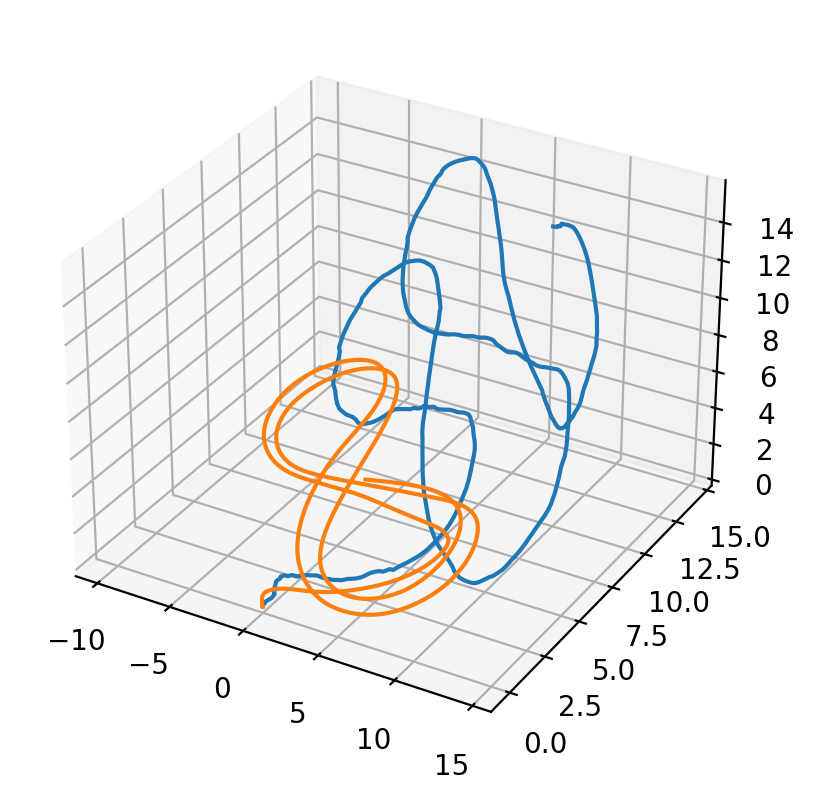

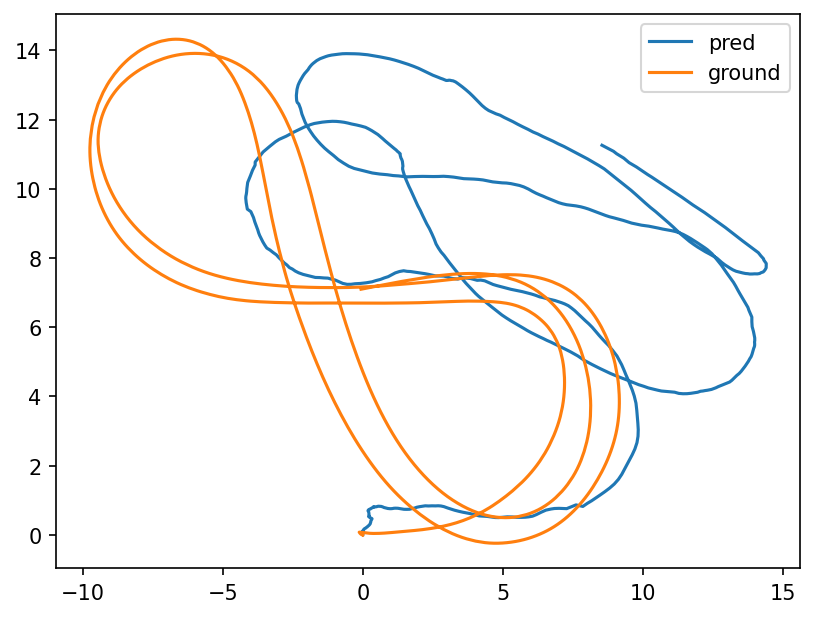

In [68]:
model.eval()
path = []
x = np.eye(4)
gtx = np.eye(4)

for i in data9_range:
    imgs, imus, gt = train_data[i]

    imgs = imgs.unsqueeze(0).to(device)
    imus = imus.unsqueeze(0).to(device)
    outputs = model(imgs, imus)
    dx = outputs.cpu().detach()

    delta_pred = matrix_from_row(dx.numpy()[0])
    # delta_pred = matrix_from_df_row(pd.Series(dx.numpy()[0], index=['tx', 'ty', 'tz', 'qx', 'qy', 'qz', 'qw']))
    x = np.matmul(x, delta_pred)
    path.append(x.copy()[:3, 3])

path = np.array(path).reshape(-1, 3)
fig = plt.figure(dpi=200)
ax = plt.axes(projection='3d')
ax.plot3D(path[:, 0], path[:, 1], path[:, 2])
ax.plot3D(ground[:, 0], ground[:, 1], ground[:, 2])

plt.figure(2, dpi=150)
plt.plot(path[:, 0], path[:, 1])
plt.plot(ground[:, 0], ground[:, 1])
plt.legend(["pred", "ground"])

In [ ]:
torch.cuda.empty_cache()
del labels
del loss
del outputs
del inputs
del dx

/tmp/ipykernel_41500/4021719166.py:13: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  trans_loss = torch.nn.functional.mse_loss(dx[:, :3], gt[:3])
/tmp/ipykernel_41500/4021719166.py:14: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([1, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  angle_loss = 50 * torch.nn.functional.mse_loss(dx[:, 3:], gt[3:])


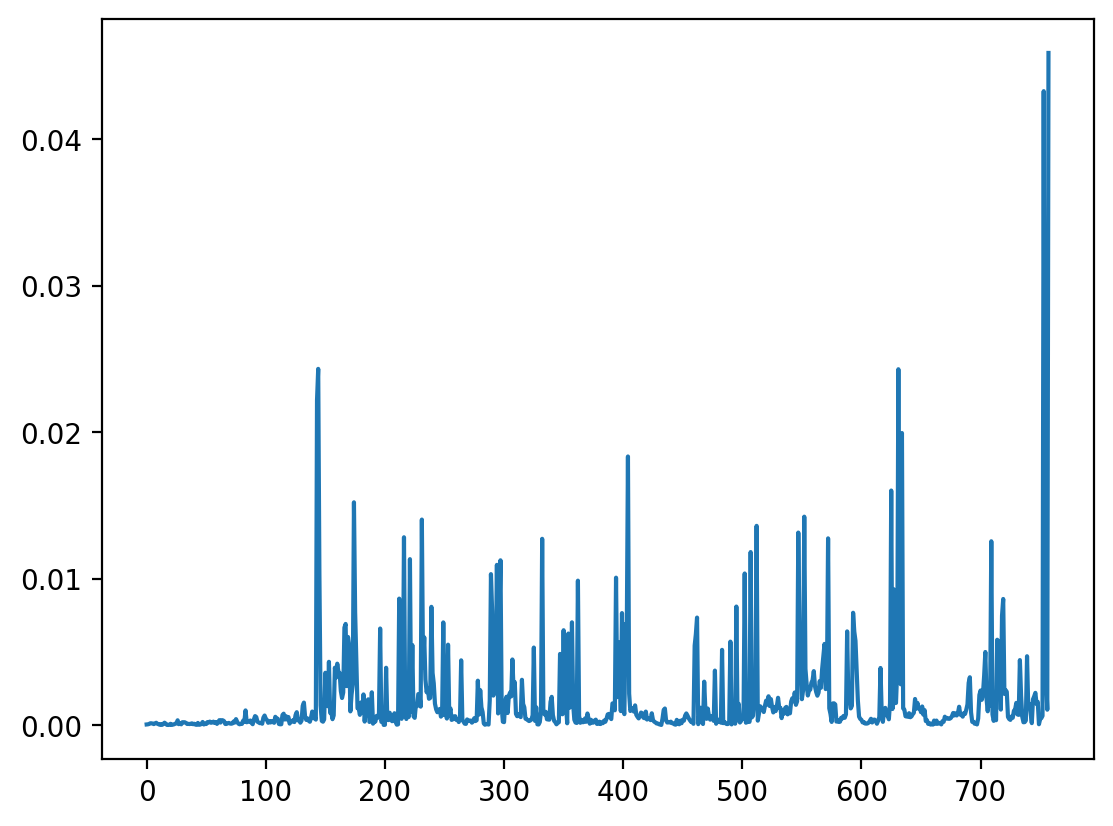

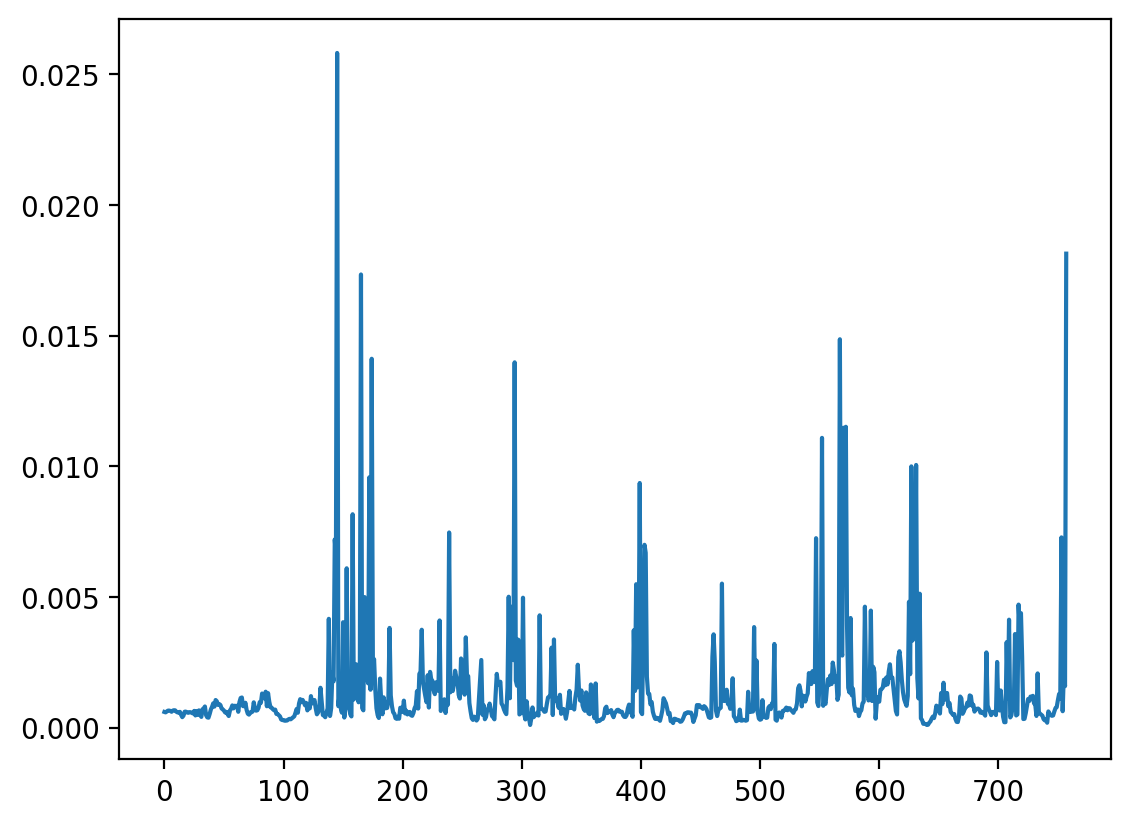

In [59]:
model.eval()
trans_diff = []
angle_diff = []

for i in data9_range:
    imgs, imus, gt = train_data[i]

    imgs = imgs.unsqueeze(0).to(device)
    imus = imus.unsqueeze(0).to(device)
    outputs = model(imgs, imus)
    dx = outputs.cpu().detach()

    trans_loss = torch.nn.functional.mse_loss(dx[:, :3], gt[:3])
    angle_loss = 50 * torch.nn.functional.mse_loss(dx[:, 3:], gt[3:])

    trans_diff.append(trans_loss)
    angle_diff.append(angle_loss)

steps = list(range(len(trans_diff)))
fig = plt.figure(dpi=200)
plt.plot(steps, trans_diff)

plt.figure(2, dpi=200)
plt.plot(steps, angle_diff)

In [64]:
print(np.mean(trans_diff), np.mean(angle_diff))

0.0017016187 0.0013488483


In [ ]:
# torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss,
#             }, 'CHOOSE_ANOTHER_NAME.mdl')

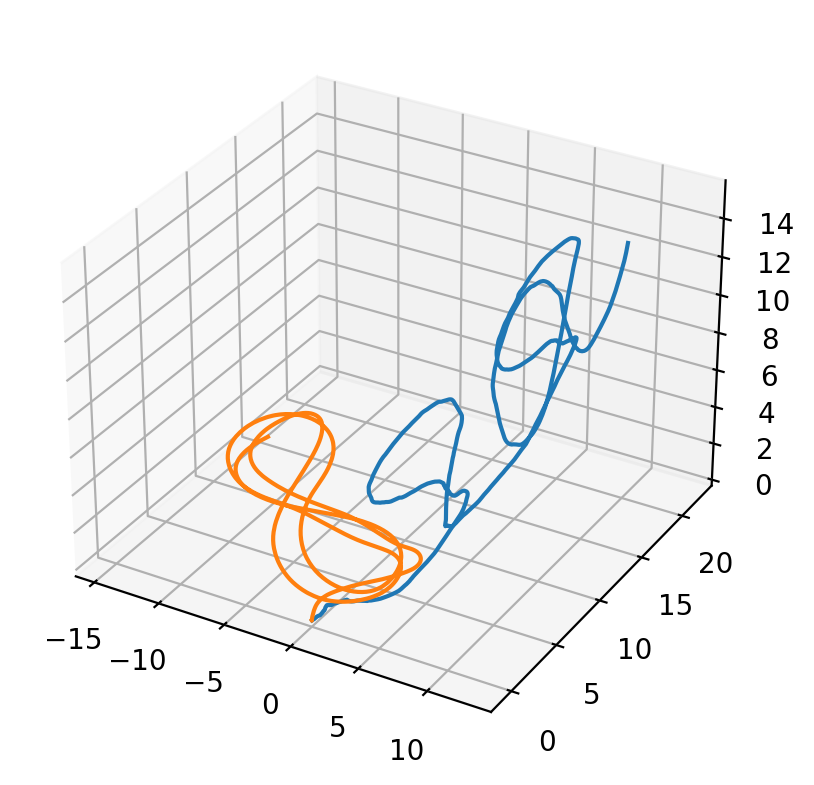

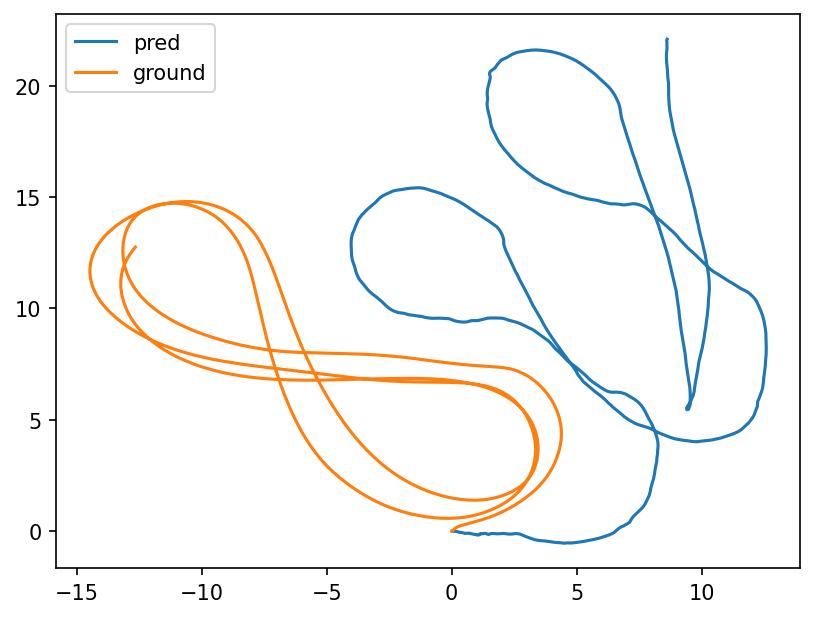

In [62]:
### >>>>>>>>>>>>>>>>>>              VALIDATION
model.eval()
path_valid = []
# ground_valid = []
x_valid = np.eye(4)
gtx_valid = np.eye(4)

results = pd.DataFrame(index=range(len(valid_data)), columns=['timestamp', 'x', 'y', 'z'])

for i in range(len(valid_data)):
    imgs, imus, gt, timestamp = valid_data[i]

    imgs = imgs.unsqueeze(0).to(device)
    imus = imus.unsqueeze(0).to(device)

    outputs = model(imgs, imus)
    dx = outputs.cpu().detach()

    delta_pred = matrix_from_row(dx.numpy()[0])
    # delta_pred = matrix_from_df_row(pd.Series(dx.numpy()[0], index=['tx', 'ty', 'tz', 'qx', 'qy', 'qz', 'qw']))
    x_valid = np.matmul(x_valid, delta_pred)
    path_valid.append(x_valid.copy()[:3, 3])

    tmp = pd.Series(index=['timestamp', 'x', 'y', 'z'], dtype=np.float64)
    tmp['timestamp'] = timestamp
    x, y, z = x_valid.copy()[:3, 3]
    tmp['x'], tmp['y'], tmp['z'] = x, y, z
    results.iloc[i] = tmp

    # delta_gt = matrix_from_row(gt)
    # gtx_valid = np.matmul(gtx_valid, delta_gt)
    # ground_valid.append(gtx_valid.copy()[:3, 3])

path_valid = np.array(path_valid).reshape(-1, 3)
# ground_valid = np.array(ground_valid).reshape(-1,3)
fig = plt.figure(dpi=200)
ax = plt.axes(projection='3d')
ax.plot3D(path_valid[:, 0], path_valid[:, 1], path_valid[:, 2])
ax.plot3D(ground_valid[:, 0], ground_valid[:, 1], ground_valid[:, 2])

plt.figure(2, dpi=150)
plt.plot(path_valid[:, 0], path_valid[:, 1])
plt.plot(ground_valid[:, 0], ground_valid[:, 1])
plt.legend(["pred", "ground"])

In [66]:
results.to_csv('stereo_imu_indoor_10.csv', index=False)